In [1123]:
import pandas as pd
import numpy as np
import xgboost as xgb


In [1124]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import *


from pandas import concat
import matplotlib.dates as md

from xgboost import XGBRegressor

In [1125]:
weather_energy = pd.read_csv('Final.csv')
weather_energy.set_index('day',inplace=True)
weather_energy.shape

(827, 15)

In [1126]:
weather_energy.head()

,avg_energy,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,WindGustKmph,cloudcover,humidity,precipMM,pressure,visibility,winddirDegree,IsBankHoliday
day,,,,,,,,,,,,,,,
2011-11-23,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,0.0,1027,7.0,257,0
2011-11-24,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,0.0,1028,10.0,205,0
2011-11-25,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024,9.0,240,0
2011-11-26,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026,10.0,229,1
2011-11-27,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021,10.0,258,1


In [1127]:
weather_energy.columns.to_list()

['avg_energy',
 'maxtempC',
 'mintempC',
 'totalSnow_cm',
 'sunHour',
 'uvIndex',
 'moon_illumination',
 'WindGustKmph',
 'cloudcover',
 'humidity',
 'precipMM',
 'pressure',
 'visibility',
 'winddirDegree',
 'IsBankHoliday']

In [1128]:
weather_energy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 827 entries, 2011-11-23 to 2014-02-26
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_energy         827 non-null    float64
 1   maxtempC           827 non-null    float64
 2   mintempC           827 non-null    float64
 3   totalSnow_cm       827 non-null    float64
 4   sunHour            827 non-null    float64
 5   uvIndex            827 non-null    float64
 6   moon_illumination  827 non-null    float64
 7   WindGustKmph       827 non-null    float64
 8   cloudcover         827 non-null    float64
 9   humidity           827 non-null    float64
 10  precipMM           827 non-null    float64
 11  pressure           827 non-null    int64  
 12  visibility         827 non-null    float64
 13  winddirDegree      827 non-null    int64  
 14  IsBankHoliday      827 non-null    int64  
dtypes: float64(12), int64(3)
memory usage: 103.4+ KB


In [1129]:
#function to convert time series data to apply supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [1130]:
def change_columnname(df):
    for cols in df.columns:
        print(cols[:4])

In [1131]:
from sklearn.preprocessing import MinMaxScaler

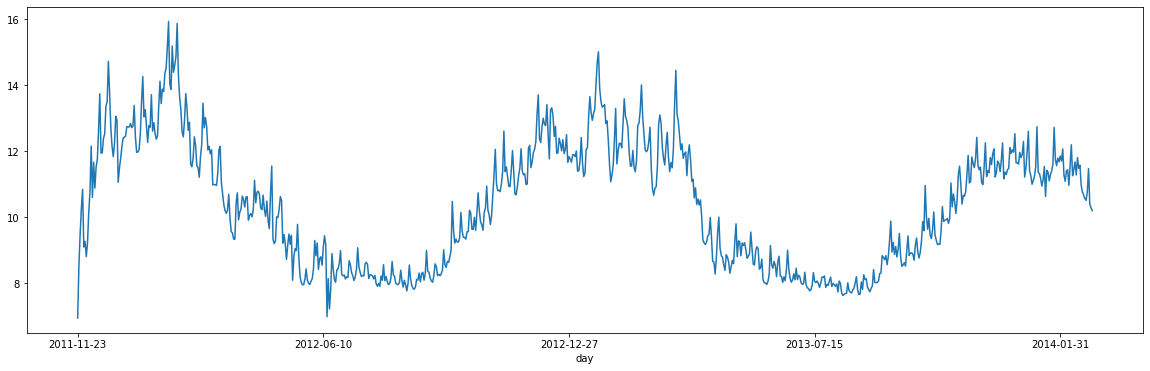

In [1132]:
weather_energy["avg_energy"].plot(figsize=(20,6));


In [1133]:
weather_energy.shape

(827, 15)

In [1134]:
weather_energy.head()

,avg_energy,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,WindGustKmph,cloudcover,humidity,precipMM,pressure,visibility,winddirDegree,IsBankHoliday
day,,,,,,,,,,,,,,,
2011-11-23,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,0.0,1027,7.0,257,0
2011-11-24,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,0.0,1028,10.0,205,0
2011-11-25,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024,9.0,240,0
2011-11-26,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026,10.0,229,1
2011-11-27,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021,10.0,258,1


In [1135]:
no_of_timesteps=6
no_of_timesteps_lead=2
reframed = series_to_supervised(weather_energy.values, no_of_timesteps,no_of_timesteps_lead)
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),...,var6(t+1),var7(t+1),var8(t+1),var9(t+1),var10(t+1),var11(t+1),var12(t+1),var13(t+1),var14(t+1),var15(t+1)
6,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,...,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0
7,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,...,2.0,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0
8,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,...,2.0,45.0,21.0,35.0,91.0,7.25,1012.0,9.0,254.0,0.0
9,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,...,2.0,52.0,36.0,60.0,91.0,7.25,1004.0,9.0,240.0,1.0
10,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,...,2.0,59.0,30.0,67.0,92.0,0.60,1001.0,10.0,246.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,11.490470,10.0,4.0,0.0,10.0,2.0,96.0,48.5,36.0,83.0,...,3.0,48.0,32.0,27.0,84.0,0.00,1009.0,10.0,223.0,1.0
822,11.582159,9.0,1.0,0.0,10.1,3.0,89.0,25.0,19.0,86.0,...,2.0,42.0,44.0,66.0,91.0,0.30,1011.0,9.0,186.0,1.0
823,10.979566,10.0,4.0,0.0,5.0,2.0,82.0,30.0,70.0,90.0,...,2.0,35.0,35.0,44.0,85.0,0.10,1006.0,10.0,175.0,0.0
824,10.781898,10.0,5.0,0.0,6.7,2.0,76.0,25.0,81.0,94.0,...,2.0,28.0,34.0,54.0,87.0,1.10,1001.0,9.0,186.0,0.0


In [1136]:
change_columnname(reframed)

var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1
var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1
var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1
var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1
var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1
var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1
var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1
var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1


In [1137]:
reframed[454:][['var1(t-1)','var1(t)','var1(t+1)']]

,var1(t-1),var1(t),var1(t+1)
460,14.014282,13.059055,12.573332
461,13.059055,12.573332,12.058759
462,12.573332,12.058759,11.990561
463,12.058759,11.990561,12.048499
464,11.990561,12.048499,12.308851
...,...,...,...
821,10.573835,10.518126,10.776242
822,10.518126,10.776242,11.480411
823,10.776242,11.480411,10.411403
824,11.480411,10.411403,10.294997


In [1138]:
reframed= reframed.reset_index(drop=True)
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),...,var6(t+1),var7(t+1),var8(t+1),var9(t+1),var10(t+1),var11(t+1),var12(t+1),var13(t+1),var14(t+1),var15(t+1)
0,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,...,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0
1,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,...,2.0,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0
2,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,...,2.0,45.0,21.0,35.0,91.0,7.25,1012.0,9.0,254.0,0.0
3,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,...,2.0,52.0,36.0,60.0,91.0,7.25,1004.0,9.0,240.0,1.0
4,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,...,2.0,59.0,30.0,67.0,92.0,0.60,1001.0,10.0,246.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,11.490470,10.0,4.0,0.0,10.0,2.0,96.0,48.5,36.0,83.0,...,3.0,48.0,32.0,27.0,84.0,0.00,1009.0,10.0,223.0,1.0
816,11.582159,9.0,1.0,0.0,10.1,3.0,89.0,25.0,19.0,86.0,...,2.0,42.0,44.0,66.0,91.0,0.30,1011.0,9.0,186.0,1.0
817,10.979566,10.0,4.0,0.0,5.0,2.0,82.0,30.0,70.0,90.0,...,2.0,35.0,35.0,44.0,85.0,0.10,1006.0,10.0,175.0,0.0
818,10.781898,10.0,5.0,0.0,6.7,2.0,76.0,25.0,81.0,94.0,...,2.0,28.0,34.0,54.0,87.0,1.10,1001.0,9.0,186.0,0.0


In [1139]:
# drop columns we don't want to predict
we_le = len(weather_energy.columns)
col_array=np.arange(0,len(reframed.columns))
reframed=reframed.loc[:,(col_array<we_le*no_of_timesteps+we_le) | (col_array%(we_le)==0)]


In [1140]:
reframed.shape

(820, 106)

In [1141]:
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),...,var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var1(t+1)
0,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,...,25.0,40.0,80.0,90.0,0.50,1010.0,9.0,205.0,0.0,8.813513
1,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,...,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0,9.227707
2,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,...,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0,10.145910
3,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,...,45.0,21.0,35.0,91.0,7.25,1012.0,9.0,254.0,0.0,10.780273
4,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,...,52.0,36.0,60.0,91.0,7.25,1004.0,9.0,240.0,1.0,12.163127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,11.490470,10.0,4.0,0.0,10.0,2.0,96.0,48.5,36.0,83.0,...,55.0,32.0,33.0,85.0,0.20,1003.0,9.0,228.0,0.0,10.776242
816,11.582159,9.0,1.0,0.0,10.1,3.0,89.0,25.0,19.0,86.0,...,48.0,32.0,27.0,84.0,0.00,1009.0,10.0,223.0,1.0,11.480411
817,10.979566,10.0,4.0,0.0,5.0,2.0,82.0,30.0,70.0,90.0,...,42.0,44.0,66.0,91.0,0.30,1011.0,9.0,186.0,1.0,10.411403
818,10.781898,10.0,5.0,0.0,6.7,2.0,76.0,25.0,81.0,94.0,...,35.0,35.0,44.0,85.0,0.10,1006.0,10.0,175.0,0.0,10.294997


In [1142]:
# reframed.drop(['var1(t)','var1(t+1)','var1(t+2)','var1(t+3)','var1(t+4)','var1(t+5)'],axis=1,inplace=True)

In [1143]:
n_train_time = 454; # hours used for training.....
original_n_train_time=n_train_time;
pred_list=[]; #predicted values that will replace the original test_y values
testing_rows=365;
#testing_rows=reframed.shape[0]-original_n_train_time-1
test1 = reframed.values[n_train_time:n_train_time+testing_rows, :] #original testing data, this will later be modified with the predicted data generated by for loop

train = reframed.values[:n_train_time, :]

train_X, train_y = train[:, :-1], train[:, -1]

# reshape input to be 3D [samples, timesteps, features]


In [1144]:
reframed[['var1(t-1)','var1(t)','var1(t+1)']]

,var1(t-1),var1(t),var1(t+1)
0,9.103382,9.274873,8.813513
1,9.274873,8.813513,9.227707
2,8.813513,9.227707,10.145910
3,9.227707,10.145910,10.780273
4,10.145910,10.780273,12.163127
...,...,...,...
815,10.573835,10.518126,10.776242
816,10.518126,10.776242,11.480411
817,10.776242,11.480411,10.411403
818,11.480411,10.411403,10.294997


In [1145]:
reframed[454:464][['var1(t-1)','var1(t)','var1(t+1)']]

,var1(t-1),var1(t),var1(t+1)
454,14.014282,13.059055,12.573332
455,13.059055,12.573332,12.058759
456,12.573332,12.058759,11.990561
457,12.058759,11.990561,12.048499
458,11.990561,12.048499,12.308851
459,12.048499,12.308851,12.735907
460,12.308851,12.735907,11.481859
461,12.735907,11.481859,10.860481
462,11.481859,10.860481,10.675248
463,10.860481,10.675248,10.889469


In [1146]:
# Training the XGBoost model after hyperparameter tuning
import time
n_iter_search = 10
param_grid = {
    'learning_rate' : np.arange(0.05, 1, 0.05),
    'max_depth': np.arange(3, 10, 1),
    'n_estimators': np.arange(10, 600, 2),
    'gamma': np.arange(0, 0.5, 0.1), 
#     'min_child_weight': np.arange(1, 20, 1), 
}
reg = XGBRegressor()
random_search = RandomizedSearchCV(reg, param_distributions=param_grid,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')

start = time.time()
random_search.fit(train_X, train_y)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
       426, 428, 430, 432, 434, 436, 438, 440, 442, 444, 446, 448, 450,
       452, 454, 456, 458, 460, 462, 464, 466, 468, 470, 472, 474, 476,
       478, 480, 482, 484, 486, 488, 490, 492, 494, 496, 498, 500, 502,
       504, 506, 508, 510, 512, 514, 516, 518, 520, 522, 524, 526, 528,
       530, 532, 534, 536, 538, 540, 542, 544, 546, 548, 550, 552, 554,
       556, 558, 560, 562, 564, 566, 568, 570, 572, 574, 576, 578, 580,
       582, 584, 586, 588, 590, 592, 594, 596, 598])},
                   scoring='neg_mean_squared_error')

In [1147]:
# best_regressor=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
#              gamma=0.2, gpu_id=-1, importance_type=None,
#              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
#              max_depth=8, min_child_weight=1,
#              monotone_constraints='()', n_estimators=94, n_jobs=8,
#              num_parallel_tree=1, predictor='auto', reg_alpha=0,
#              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
#              validate_parameters=1, verbosity=None)
# best_regressor.fit(train_X, train_y)

In [1148]:
best_regressor = random_search.best_estimator_
best_regressor

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.30000000000000004, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=286, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [1149]:
for j in range(0,testing_rows+1):
    print('Loop # ',j)
    print(reframed.values[n_train_time,(len(reframed.columns)-1-we_le)])
    test = reframed.values[n_train_time:n_train_time+1, :]
    test_X = test[:, :-1]
    test_y = test[:, -1]
    print(reframed[n_train_time:n_train_time+1])
    yhat = model.predict(test_X)
    if n_train_time+1<len(reframed):
        for k in range(0,len(reframed.columns),we_le):
            if((k+we_le)<(len(reframed.columns)-1)):
                reframed.values[n_train_time+1,k]=reframed.values[n_train_time,(k+we_le)];
        print(n_train_time+1,(len(reframed.columns)-1-we_le))
        print(reframed.values[n_train_time+1,(len(reframed.columns)-1-we_le)])
        reframed.values[n_train_time+1,(len(reframed.columns)-1-we_le)]=yhat;
        print(n_train_time+1,(len(reframed.columns)-1-we_le))
        print(reframed.values[n_train_time+1,(len(reframed.columns)-1-we_le)])
    n_train_time=n_train_time+1
    pred_list=np.append(pred_list,yhat)
    y_true=np.append(y_true,test_y)
    print(reframed[n_train_time-1:n_train_time])
    print(test_y,yhat)
n_train_time=original_n_train_time

Loop #  0
13.05905549357143
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
454  11.385007       10.0        0.0        0.0       10.2        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
454       59.0        9.0       20.0        81.0  ...    100.0     29.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
454     86.0      86.0       0.4    1026.0       8.0     182.0       0.0   

     var1(t+1)  
454  12.573332  

[1 rows x 106 columns]
check test ends x --->
starts here
455 90
12.573332295915002
ends here
starts here
455 90
13.110030174255371
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
454  11.385007       10.0        0.0        0.0       10.2        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
454       59.0        9.0       20.0        81.0  ...    100.0     29.0   

     var9(t)  var10(t)  var11

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
466  13.212983        7.0        1.0        0.0       10.1        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
466       60.0       14.0       35.0        85.0  ...     19.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
466     78.0      92.0       4.1    1002.0       7.0     252.0       1.0   

     var1(t+1)  
466  12.823073  

[1 rows x 106 columns]
[12.82307273] [12.157453]
Loop #  13
12.157452583312988
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
467  12.865069        9.0        0.0        0.0       11.1        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
467       53.0       24.0       34.0        86.0  ...     12.0     27.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
467     87.0      87.0       0.8    1006.0  

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
474  12.154555        1.0       -2.0        0.2        5.7        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
474        5.0       41.0       86.0        71.0  ...     35.0     24.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
474     82.0      96.0       5.9     991.0       7.0     208.0       1.0   

     var1(t+1)  
474  11.816573  

[1 rows x 106 columns]
[11.81657259] [12.552736]
Loop #  21
12.552736282348633
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
475  12.156859        4.0       -2.0        0.0        8.7        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
475        1.0       37.0       60.0        63.0  ...     42.0     10.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
475     68.0      91.0       1.8     991.0  

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
482  12.541695        8.0        0.0        0.0        7.4        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
482       49.0       12.0       76.0        86.0  ...     89.0     31.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
482     73.0      72.0       0.4    1014.0       7.0      46.0       0.0   

     var1(t+1)  
482  12.916559  

[1 rows x 106 columns]
[12.91655945] [13.026365]
Loop #  29
13.026365280151367
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
483  12.607815        7.0        1.0        0.0        7.4        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
483       56.0       14.0       79.0        87.0  ...     96.0     27.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
483     69.0      72.0       0.7    1013.0  

starts here
492 90
12.201972247382052
ends here
starts here
492 90
13.33159351348877
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
491  13.114887        5.0       -3.0        0.2        7.7        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
491       90.0       22.0       56.0        73.0  ...     50.0     32.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
491     51.0      73.0       0.4    1018.0       8.0      33.0       0.0   

     var1(t+1)  
491  12.201972  

[1 rows x 106 columns]
[12.20197225] [13.3315935]
Loop #  38
13.33159351348877
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
492  13.052037        6.0       -3.0        0.0        9.0        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
492       83.0       20.0       35.0        75.0  ...     43.0     33.0   

     var9(t)  var10(t)  v

starts here
500 90
10.372293049156626
ends here
starts here
500 90
11.968496322631836
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
499  13.544004        7.0       -1.0        0.3        6.6        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
499       36.0       33.0       78.0        75.0  ...      5.0     19.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
499     75.0      92.0      7.25     997.0       8.0     103.0       0.0   

     var1(t+1)  
499  10.372293  

[1 rows x 106 columns]
[10.37229305] [11.968496]
Loop #  46
11.968496322631836
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
500  14.073229       10.0       -1.0        0.0       11.6        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
500       29.0       19.0       29.0        76.0  ...     11.0     24.0   

     var9(t)  var10(t)  

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
506  11.968496       11.0        5.0        0.0        6.7        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
506       11.0       24.0       78.0        93.0  ...     52.0     38.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
506     28.0      76.0       0.8    1013.0      10.0     230.0       0.0   

     var1(t+1)  
506   9.449012  

[1 rows x 106 columns]
[9.44901226] [11.556824]
Loop #  53
11.55682373046875
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
507  11.992512       13.0        3.0        0.0        7.9        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
507       18.0       27.0       75.0        90.0  ...     59.0     23.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
507     44.0      81.0       2.4    1025.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
513  11.556824       12.0        4.0        0.0       12.3        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
513       59.0       23.0       44.0        81.0  ...     99.0     17.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
513     59.0      82.0       0.3    1021.0       8.0     234.0       0.0   

     var1(t+1)  
513   8.778425  

[1 rows x 106 columns]
[8.77842515] [10.466793]
Loop #  60
10.466793060302734
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
514  11.942264       14.0        4.0        0.0       14.5        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
514       66.0       11.0        0.0        73.0  ...     94.0     19.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
514     49.0      80.0       3.2    1015.0   

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
521  10.835904       10.0        1.0        0.0       10.3        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
521       87.0       19.0       57.0        80.0  ...     46.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
521     11.0      70.0       0.0    1020.0      10.0     245.0       0.0   

     var1(t+1)  
521   8.868706  

[1 rows x 106 columns]
check test ends x --->
starts here
522 90
8.868705563111856
ends here
starts here
522 90
10.18185043334961
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
521  10.835904       10.0        1.0        0.0       10.3        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
521       87.0       19.0       57.0        80.0  ...     46.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \


starts here
529 90
9.276239665363128
ends here
starts here
529 90
10.172423362731934
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
528   10.18185       14.0        6.0        0.0       10.4        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
528       40.0       26.0       45.0        80.0  ...      1.0     30.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
528     73.0      83.0       1.6    1010.0       9.0     229.0       0.0   

     var1(t+1)  
528    9.27624  

[1 rows x 106 columns]
[9.27623967] [10.172423]
Loop #  75
10.172423362731934
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
529  10.727176       18.0        4.0        0.0       12.5        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
529       33.0       10.0       67.0        79.0  ...      8.0     26.0   

     var9(t)  var10(t)  va

starts here
537 90
9.233726035565088
ends here
starts here
537 90
10.649190902709961
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
536  10.326885       14.0        3.0        0.0       12.5        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
536       15.0       26.0       64.0        85.0  ...     55.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
536     46.0      78.0       0.1    1008.0       8.0     246.0       1.0   

     var1(t+1)  
536   9.233726  

[1 rows x 106 columns]
[9.23372604] [10.649191]
Loop #  83
10.649190902709961
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
537   9.913327       13.0        7.0        0.0       12.5        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
537       21.0       29.0       61.0        78.0  ...     62.0     14.0   

     var9(t)  var10(t)  va

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
543  10.649191       18.0        7.0        0.0       13.5        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
543       62.0       14.0       31.0        76.0  ...     97.0     18.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
543     52.0      78.0       0.5    1020.0      10.0     264.0       1.0   

     var1(t+1)  
543   8.584917  

[1 rows x 106 columns]
[8.58491657] [10.504746]
Loop #  90
10.504746437072754
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
544  10.005739       17.0        9.0        0.0        9.7        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
544       69.0       20.0       88.0        90.0  ...     91.0     18.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
544     33.0      67.0       0.0    1018.0   

starts here
552 90
8.11301942072829
ends here
starts here
552 90
10.280547142028809
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
551   9.983446       16.0        7.0        0.0       16.5        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
551       84.0       21.0        7.0        70.0  ...     43.0     17.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
551     32.0      73.0       0.1    1028.0       9.0     267.0       1.0   

     var1(t+1)  
551   8.113019  

[1 rows x 106 columns]
[8.11301942] [10.280547]
Loop #  98
10.280547142028809
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
552   9.454324       13.0        9.0        0.0       12.4        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
552       77.0       13.0       93.0        96.0  ...     36.0     16.0   

     var9(t)  var10(t)  var

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
560   9.126498       20.0        7.0        0.0       16.6        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
560       23.0       16.0       35.0        79.0  ...     18.0     20.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
560     78.0      90.0       1.2    1014.0       5.0     159.0       0.0   

     var1(t+1)  
560   8.666902  

[1 rows x 106 columns]
check test ends x --->
starts here
561 90
8.666901835294118
ends here
starts here
561 90
9.064532279968262
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
560   9.126498       20.0        7.0        0.0       16.6        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
560       23.0       16.0       35.0        79.0  ...     18.0     20.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \


     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
567   9.064532       18.0       13.0        0.0       12.6        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
567       25.0       29.0       95.0        91.0  ...     65.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
567     65.0      89.0       4.8    1014.0       9.0     131.0       0.0   

     var1(t+1)  
567   8.032087  

[1 rows x 106 columns]
[8.03208653] [8.234414]
Loop #  114
8.234414100646973
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
568   8.374086       17.0       12.0        0.0       13.4        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
568       31.0       31.0       80.0        84.0  ...     72.0      9.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
568     54.0      83.0       0.2    1015.0    

starts here
575 90
8.036278860813344
ends here
starts here
575 90
8.194145202636719
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
574   8.234414       27.0       14.0        0.0       16.6        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
574       72.0        9.0       54.0        83.0  ...     87.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
574     25.0      70.0       0.1    1029.0       9.0     291.0       0.0   

     var1(t+1)  
574   8.036279  

[1 rows x 106 columns]
[8.03627886] [8.194145]
Loop #  121
8.194145202636719
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
575   8.231999       20.0       14.0        0.0       12.6        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
575       79.0       12.0       92.0        94.0  ...     81.0     11.0   

     var9(t)  var10(t)  var1

starts here
582 90
8.195046502775174
ends here
starts here
582 90
8.216476440429688
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
581   8.194145       20.0        9.0        0.0       15.0        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
581       81.0       11.0       56.0        75.0  ...     40.0     16.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
581     68.0      77.0       0.1    1011.0       9.0     201.0       0.0   

     var1(t+1)  
581   8.195047  

[1 rows x 106 columns]
[8.1950465] [8.216476]
Loop #  128
8.216476440429688
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
582   8.066619       20.0       11.0        0.0       14.2        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
582       74.0       13.0       71.0        78.0  ...     33.0     18.0   

     var9(t)  var10(t)  var11

starts here
589 90
7.847244306568793
ends here
starts here
589 90
8.028082847595215
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
588   8.216476       21.0       13.0        0.0       14.2        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
588       33.0       18.0       70.0        81.0  ...      7.0     16.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
588     27.0      66.0       0.0    1028.0       8.0      41.0       0.0   

     var1(t+1)  
588   7.847244  

[1 rows x 106 columns]
[7.84724431] [8.028083]
Loop #  135
8.028082847595215
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
589   8.250731       22.0       10.0        0.0       15.0        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
589       26.0       19.0       52.0        81.0  ...     14.0     18.0   

     var9(t)  var10(t)  var1

starts here
597 90
8.00012283381688
ends here
starts here
597 90
8.118349075317383
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
596   8.028083       22.0        8.0        0.0       16.6        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
596       21.0       14.0       39.0        75.0  ...     62.0      9.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
596     19.0      62.0       0.9    1024.0      10.0     131.0       0.0   

     var1(t+1)  
596   8.000123  

[1 rows x 106 columns]
[8.00012283] [8.118349]
Loop #  143
8.118349075317383
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
597   8.019053       25.0        9.0        0.0       16.6        6.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
597       28.0        9.0       41.0        74.0  ...     68.0     15.0   

     var9(t)  var10(t)  var11

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
604   8.199373       26.0       13.0        0.0       16.0        6.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
604       75.0       18.0       15.0        69.0  ...     84.0     17.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
604     30.0      73.0       0.4    1013.0       8.0     190.0       0.0   

     var1(t+1)  
604   7.936592  

[1 rows x 106 columns]
check test ends x --->
starts here
605 90
7.936591656314896
ends here
starts here
605 90
8.2073335647583
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
604   8.199373       26.0       13.0        0.0       16.0        6.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
604       75.0       18.0       15.0        69.0  ...     84.0     17.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
60

[7.98315031] [8.000539]
Loop #  158
8.00053882598877
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
612   8.191308       27.0       14.0        0.0       12.5        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
612       71.0        8.0       51.0        72.0  ...     30.0     17.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
612     18.0      74.0       0.3    1009.0      10.0     210.0       0.0   

     var1(t+1)  
612   7.741152  

[1 rows x 106 columns]
check test ends x --->
starts here
613 90
7.741152230937972
ends here
starts here
613 90
7.977720260620117
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
612   8.191308       27.0       14.0        0.0       12.5        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
612       71.0        8.0       51.0        72.0  ...     30.0     17.0   

     v

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
619    7.97772       23.0       14.0        0.0       14.5        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
619       23.0       22.0       20.0        68.0  ...     17.0     19.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
619     60.0      71.0       0.9    1019.0      10.0     255.0       0.0   

     var1(t+1)  
619   7.703308  

[1 rows x 106 columns]
[7.70330809] [8.240699]
Loop #  166
8.24069881439209
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
620   8.189129       23.0       13.0        0.0       12.5        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
620       17.0       21.0       58.0        71.0  ...     24.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
620     45.0      63.0       0.2    1022.0     

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
628   8.276792       20.0       12.0        0.0       11.4        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
628       38.0       17.0       49.0        65.0  ...     78.0     19.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
628     55.0      74.0       0.7    1010.0      10.0     235.0       1.0   

     var1(t+1)  
628   7.809359  

[1 rows x 106 columns]
check test ends x --->
starts here
629 90
7.80935943712222
ends here
starts here
629 90
8.259533882141113
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
628   8.276792       20.0       12.0        0.0       11.4        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
628       38.0       17.0       49.0        65.0  ...     78.0     19.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
6

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
639   8.108261       26.0       15.0        0.0       13.4        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
639       88.0       16.0       61.0        75.0  ...     47.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
639     33.0      71.0       0.0    1022.0       9.0     264.0       0.0   

     var1(t+1)  
639    7.85505  

[1 rows x 106 columns]
[7.85504989] [7.9506903]
Loop #  186
7.950690269470215
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
640   8.304651       18.0       15.0        0.0        9.9        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
640       81.0       18.0       86.0        92.0  ...     40.0     16.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
640     47.0      78.0       0.1    1020.0   

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
646    7.95069       23.0       15.0        0.0       10.4        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
646       40.0       16.0       47.0        78.0  ...      0.0      8.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
646      9.0      73.0       3.4    1012.0       7.0     170.0       0.0   

     var1(t+1)  
646   8.301363  

[1 rows x 106 columns]
[8.30136296] [8.212777]
Loop #  193
8.212777137756348
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
647   8.062119       21.0       14.0        0.0       11.6        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
647       34.0       18.0       34.0        67.0  ...      7.0     14.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
647     44.0      82.0      7.25    1009.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
655   8.483239       17.0        9.0        0.0        9.1        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
655       21.0       14.0       33.0        80.0  ...     61.0     18.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
655     67.0      87.0      7.25    1015.0       8.0     251.0       1.0   

     var1(t+1)  
655   9.889958  

[1 rows x 106 columns]
check test ends x --->
starts here
656 90
9.889957584581582
ends here
starts here
656 90
9.091992378234863
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
655   8.483239       17.0        9.0        0.0        9.1        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
655       21.0       14.0       33.0        80.0  ...     61.0     18.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \


     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
662   9.091992       14.0        7.0        0.0        7.7        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
662       68.0       27.0       49.0        85.0  ...     91.0     16.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
662     71.0      90.0       0.7    1024.0       7.0     229.0       1.0   

     var1(t+1)  
662   9.512709  

[1 rows x 106 columns]
[9.51270876] [9.1802635]
Loop #  209
9.18026351928711
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
663   8.784465       14.0        7.0        0.0       11.6        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
663       75.0       27.0       19.0        76.0  ...     85.0     11.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
663     53.0      89.0       0.1    1027.0    

[1 rows x 106 columns]
[9.44085265] [8.892446]
Loop #  216
8.89244556427002
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
670   9.066738       23.0       11.0        0.0        8.8        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
670       78.0        9.0       47.0        87.0  ...     37.0     24.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
670     32.0      74.0       0.0    1007.0      10.0      60.0       1.0   

     var1(t+1)  
670   8.845674  

[1 rows x 106 columns]
check test ends x --->
starts here
671 90
8.845674203315447
ends here
starts here
671 90
8.351167678833008
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
670   9.066738       23.0       11.0        0.0        8.8        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
670       78.0        9.0       47.0        87.0  ...     3

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
678   8.045341       18.0       11.0        0.0        7.2        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
678       24.0       21.0       65.0        79.0  ...     17.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
678     41.0      83.0       0.0    1025.0       7.0     236.0       0.0   

     var1(t+1)  
678   8.768965  

[1 rows x 106 columns]
check test ends x --->
starts here
679 90
8.768964841191163
ends here
starts here
679 90
8.448479652404785
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
678   8.045341       18.0       11.0        0.0        7.2        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
678       24.0       21.0       65.0        79.0  ...     17.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \


[1 rows x 106 columns]
check test ends x --->
starts here
686 90
9.642349740453758
ends here
starts here
686 90
9.185996055603027
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
685    8.44848       21.0       13.0        0.0       10.1        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
685       24.0       16.0       62.0        86.0  ...     64.0     18.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
685     96.0      94.0       2.7    1007.0       7.0     238.0       0.0   

     var1(t+1)  
685    9.64235  

[1 rows x 106 columns]
[9.64234974] [9.185996]
Loop #  232
9.185996055603027
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
686   8.378216       15.0        9.0        0.0        8.6        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
686       30.0       21.0       70.0        83.0  ...     

starts here
693 90
9.311661470284834
ends here
starts here
693 90
9.178351402282715
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
692   9.185996       13.0        7.0        0.0       10.8        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
692       71.0       16.0       59.0        89.0  ...     88.0     31.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
692     59.0      93.0       0.7    1006.0       8.0     184.0       0.0   

     var1(t+1)  
692   9.311661  

[1 rows x 106 columns]
[9.31166147] [9.178351]
Loop #  239
9.178351402282715
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
693   9.224048       14.0        6.0        0.0        6.9        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
693       78.0       25.0       62.0        96.0  ...     81.0     32.0   

     var9(t)  var10(t)  var1

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
704   9.378341       15.0       11.0        0.0        7.0        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
704       48.0       37.0       57.0        83.0  ...      7.0     25.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
704     66.0      89.0       0.7     999.0       6.0     187.0       1.0   

     var1(t+1)  
704  11.044186  

[1 rows x 106 columns]
[11.04418563] [9.601006]
Loop #  251
9.601005554199219
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
705   9.184138       14.0        8.0        0.0        5.4        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
705       41.0       40.0       61.0        85.0  ...      0.0     35.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
705     27.0      81.0       2.4     999.0   

[1 rows x 106 columns]
[11.00790902] [9.460435]
Loop #  259
9.460434913635254
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
713   9.201271       12.0        4.0        0.0        5.2        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
713       13.0       28.0       55.0        91.0  ...     54.0     28.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
713     78.0      94.0       4.8    1022.0       8.0     180.0       0.0   

     var1(t+1)  
713  10.404713  

[1 rows x 106 columns]
check test ends x --->
starts here
714 90
10.404712577565586
ends here
starts here
714 90
9.174004554748535
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
713   9.201271       12.0        4.0        0.0        5.2        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
713       13.0       28.0       55.0        91.0  ...   

[1 rows x 106 columns]
check test ends x --->
starts here
721 90
11.095023002976996
ends here
starts here
721 90
9.844234466552734
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
720   9.174005       11.0        8.0        0.0        6.9        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
720       61.0       18.0       57.0        93.0  ...    100.0     10.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
720     88.0      95.0       0.5    1011.0       3.0     254.0       0.0   

     var1(t+1)  
720  11.095023  

[1 rows x 106 columns]
[11.095023] [9.844234]
Loop #  267
9.844234466552734
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
721   9.816748        9.0        4.0        0.0        8.7        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
721       68.0       14.0       12.0        87.0  ...     

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
727   9.844234        5.0        1.0        0.0        8.7        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
727       92.0       25.0       19.0        87.0  ...     51.0     24.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
727     36.0      92.0       0.0    1037.0      10.0     344.0       0.0   

     var1(t+1)  
727  11.443268  

[1 rows x 106 columns]
[11.4432682] [11.919361]
Loop #  274
11.919361114501953
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
728   10.24523        5.0       -1.0        0.0        5.1        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
728       85.0       29.0       56.0        93.0  ...     44.0     18.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
728     41.0      92.0       0.0    1038.0  

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
734  11.919361        6.0        0.0        0.0        8.2        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
734       44.0       18.0       41.0        92.0  ...      4.0     17.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
734     54.0      94.0       0.0    1034.0       5.0      45.0       0.0   

     var1(t+1)  
734  11.414006  

[1 rows x 106 columns]
[11.41400624] [12.289409]
Loop #  281
12.289408683776855
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
735  11.672934        9.0        2.0        0.0        3.1        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
735       38.0       11.0       94.0        97.0  ...      3.0     10.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
735     54.0      88.0       0.0    1029.0 

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
743  12.256311        8.0        0.0        0.0        6.8        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
743       17.0       42.0       22.0        88.0  ...     57.0     20.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
743     12.0      88.0       0.0    1029.0       9.0     161.0       0.0   

     var1(t+1)  
743   11.64128  

[1 rows x 106 columns]
check test ends x --->
starts here
744 90
11.641280485045998
ends here
starts here
744 90
12.653254508972168
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
743  12.256311        8.0        0.0        0.0        6.8        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
743       17.0       42.0       22.0        88.0  ...     57.0     20.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  

[1 rows x 106 columns]
[11.29992329] [12.393439]
Loop #  296
12.393439292907715
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
750  12.653255        9.0        4.0        0.0        6.8        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
750       64.0       26.0       40.0        92.0  ...     95.0     37.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
750     68.0      93.0       5.6    1009.0       7.0     199.0       0.0   

     var1(t+1)  
750  11.444299  

[1 rows x 106 columns]
check test ends x --->
starts here
751 90
11.444299355214245
ends here
starts here
751 90
12.15272045135498
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
750  12.653255        9.0        4.0        0.0        6.8        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
750       64.0       26.0       40.0        92.0  ... 

starts here
764 90
12.302586389860757
ends here
starts here
764 90
12.343463897705078
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
763  11.691884        8.0        3.0        0.0        5.8        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
763       48.0       25.0       34.0        90.0  ...      7.0     34.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
763     72.0      95.0       4.4    1005.0       9.0     182.0       0.0   

     var1(t+1)  
763  12.302586  

[1 rows x 106 columns]
[12.30258639] [12.343464]
Loop #  310
12.343463897705078
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
764  11.838326        6.0        1.0        0.0        5.8        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
764       41.0       20.0       34.0        93.0  ...      1.0     47.0   

     var9(t)  var10(t) 

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
778  12.339856        9.0        4.0        0.0        3.9        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
778       54.0       38.0       61.0        91.0  ...     94.0     32.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
778     97.0      96.0       5.9     999.0       8.0     189.0       0.0   

     var1(t+1)  
778  10.950308  

[1 rows x 106 columns]
check test ends x --->
starts here
779 90
10.95030754302028
ends here
starts here
779 90
12.294239044189453
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
778  12.339856        9.0        4.0        0.0        3.9        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
778       54.0       38.0       61.0        91.0  ...     94.0     32.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \

starts here
786 90
11.300413875620812
ends here
starts here
786 90
12.145528793334961
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
785  12.294239       10.0        6.0        0.0        6.9        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
785      100.0       32.0       59.0        90.0  ...     58.0     23.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
785     72.0      93.0       4.8    1007.0       8.0     208.0       0.0   

     var1(t+1)  
785  11.300414  

[1 rows x 106 columns]
[11.30041388] [12.145529]
Loop #  332
12.145528793334961
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
786  12.212474        9.0        5.0        0.0        6.9        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
786       92.0       34.0       59.0        89.0  ...     52.0     30.0   

     var9(t)  var10(t) 

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
793  12.033849        7.0        1.0        0.0        3.3        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
793       45.0       21.0       83.0        94.0  ...      4.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
793     92.0      97.0       3.8    1002.0       5.0      94.0       0.0   

     var1(t+1)  
793  11.857957  

[1 rows x 106 columns]
check test ends x --->
starts here
794 90
11.857956924876506
ends here
starts here
794 90
12.813311576843262
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
793  12.033849        7.0        1.0        0.0        3.3        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
793       45.0       21.0       83.0        94.0  ...      4.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  

starts here
801 90
10.972318254623016
ends here
starts here
801 90
11.484560012817383
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
800  12.813312        7.0        1.0        0.0        5.2        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
800        3.0       32.0       84.0        95.0  ...     43.0     39.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
800     67.0      92.0      7.25     990.0       9.0     188.0       0.0   

     var1(t+1)  
800  10.972318  

[1 rows x 106 columns]
[10.97231825] [11.48456]
Loop #  347
11.484560012817383
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
801  12.813475        8.0        4.0        0.0        8.7        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
801        9.0       40.0       53.0        85.0  ...     50.0     35.0   

     var9(t)  var10(t)  

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
812  11.587119        7.0        1.0        0.0        6.6        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
812       84.0       47.0       58.0        91.0  ...     76.0     25.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
812     81.0      94.0       4.3    1008.0       7.0     201.0       0.0   

     var1(t+1)  
812  10.674624  

[1 rows x 106 columns]
[10.6746236] [11.719309]
Loop #  359
11.719308853149414
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
813  11.705895        7.0        3.0        0.0        9.9        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
813       91.0       37.0       28.0        80.0  ...     69.0     23.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
813     70.0      93.0       0.3    1011.0  

In [1150]:
len(pred_list)

366

In [1151]:
list1 = reframed['var1(t+1)'][:454]

In [1152]:
len(list1)

454

In [1153]:
list1

0       8.813513
1       9.227707
2      10.145910
3      10.780273
4      12.163127
         ...    
449    12.791991
450    12.856232
451    13.245570
452    14.014282
453    13.059055
Name: var1(t+1), Length: 454, dtype: float64

In [1154]:
len(reframed)

820

In [1155]:
list1 = list1.to_list()
pred_list = list(pred_list)
list2 = list1 + pred_list

In [1156]:
reframed[454:464][['var1(t-1)','var1(t)','var1(t+1)']]

,var1(t-1),var1(t),var1(t+1)
454,14.014282,13.059055,12.573332
455,13.059055,13.110030,12.058759
456,13.110030,12.862425,11.990561
457,12.862425,12.659937,12.048499
458,12.659937,12.466146,12.308851
459,12.466146,12.848974,12.735907
460,12.848974,13.212983,11.481859
461,13.212983,12.865069,10.860481
462,12.865069,12.176340,10.675248
463,12.176340,11.735680,10.889469


In [1157]:
reframed.loc[454]

var1(t-6)      11.385007
var2(t-6)      10.000000
var3(t-6)       0.000000
var4(t-6)       0.000000
var5(t-6)      10.200000
                ...     
var12(t)     1026.000000
var13(t)        8.000000
var14(t)      182.000000
var15(t)        0.000000
var1(t+1)      12.573332
Name: 454, Length: 106, dtype: float64

In [1158]:
reframed['predictedlist'] = list2


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1159]:
reframed[454:][['var1(t-1)','var1(t)','var1(t+1)','predictedlist']]

,var1(t-1),var1(t),var1(t+1),predictedlist
454,14.014282,13.059055,12.573332,13.110030
455,13.059055,13.110030,12.058759,12.862425
456,13.110030,12.862425,11.990561,12.659937
457,12.862425,12.659937,12.048499,12.466146
458,12.659937,12.466146,12.308851,12.848974
...,...,...,...,...
815,11.540672,11.392173,10.776242,11.864421
816,11.392173,11.864421,11.480411,12.190978
817,11.864421,12.190978,10.411403,11.643340
818,12.190978,11.643340,10.294997,11.431621


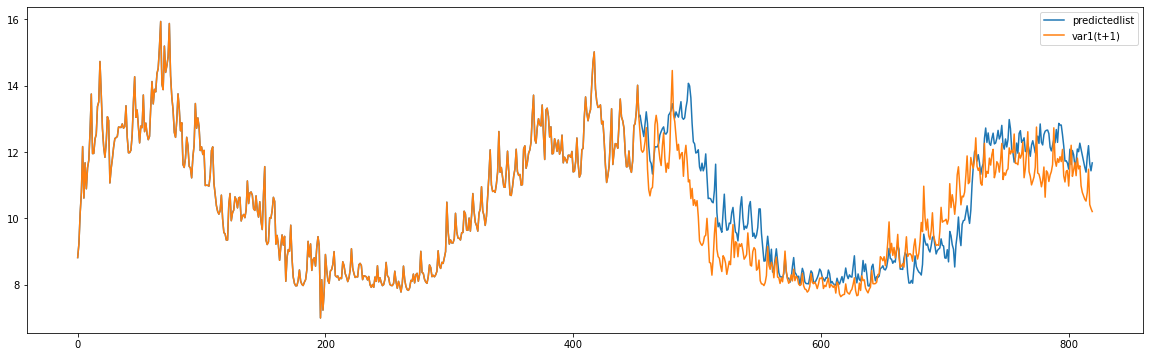

In [1160]:
reframed[["predictedlist","var1(t+1)"]].plot(figsize=(20,6));

Text(0.5, 0, 'Time')

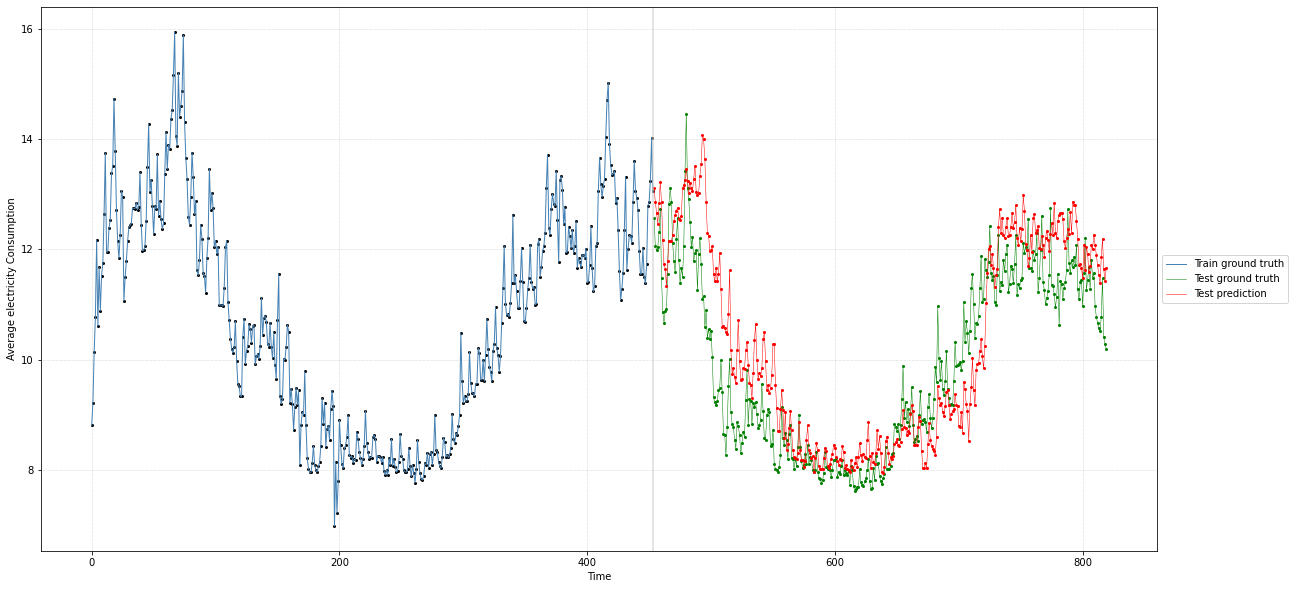

In [1161]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(20, 10), sharex=True)

train = reframed[:454]
axes.plot(train.index, train['var1(t+1)'], 'ko', markersize=2, )
axes.plot(train.index, train['var1(t+1)'], color='steelblue', lw=1,label='Train ground truth')

test = reframed[454:]
axes.plot(test.index, test['var1(t+1)'], 'go', markersize=2, )
axes.plot(test.index, test['var1(t+1)'], 'g', lw=0.5, label='Test ground truth')
axes.plot(test.index, test.predictedlist, color='red', lw=0.5, label='Test prediction')
axes.plot(test.index, test.predictedlist, 'ro', markersize=2, )

axes.axvline(train.index[-1], color='0.8', alpha=0.7)
axes.set_ylabel(f'Average electricity Consumption')
axes.grid(ls=':', lw=0.5)
axes.legend(loc='center left', bbox_to_anchor=(1,0.5))
axes.set_xlabel('Time')

In [1162]:
import numpy as np
from sklearn.metrics import mean_absolute_error


print(mean_absolute_error(y_true, pred_list))

0.73213354387481


In [1163]:
import shap

In [1164]:
X_test = reframed[454:].drop(['var1(t+1)','predictedlist'],axis=1)

In [1165]:
def plot_abs_SHAP_summary(df_x, df_shap, max_display=None, shap_name = 'shap_plot', clean_name_dict={}, save=False):
    
    """ SHAP Summary Plot """
    
    import shap
    
    # Get correlations and importances
    corrs = df_x.corrwith(df_shap)
    shap_importances = df_shap.abs().mean()
    shap_importances.sort_values(ascending=False, inplace=True)
    corrs = corrs.loc[shap_importances.index]
    
    # Configure plot inputs
    if not max_display:
        max_display = len(shap_importances)
    shap_importances = shap_importances.iloc[:max_display]
    corrs = corrs.iloc[:max_display]
    norm = plt.Normalize(corrs.min(), corrs.max())
    colors = plt.cm.coolwarm(norm(corrs)) 
    scalar_color_map = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm) #if you don't like my colors, change here
    scalar_color_map.set_array([])
    labels = shap_importances.index.tolist()
    if len(clean_name_dict) > 0:
        labels = [ clean_name_dict.get(item,item) for item in labels ]
        
    
    # Plot
    plt.figure(figsize=(12,len(shap_importances)*0.5))
    sns.barplot(x=shap_importances, y=np.arange(len(shap_importances)), orient='h', palette=colors, edgecolor="black")
    sns.despine(top=True, right=True)
    colorbar = plt.colorbar(scalar_color_map, aspect=50)
    colorbar.set_label('SHAP-feature correlation', fontsize=14)
    colorbar.set_ticks(np.arange(-1,1.25,0.25))
    plt.yticks(np.arange(len(shap_importances)), labels=labels, fontsize=12)
    plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontsize=14)
    plt.title('SHAP feature importance', fontsize=18)
    # Save plot #
    if save:
        timestmp = datetime.now().strftime("%d%m%Y_%H%M%S")
        plt.savefig('outputs/{}_{}.jpg'.format(shap_name,timestmp), dpi = 200, bbox_inches='tight')
    plt.show()

In [1166]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
df_shap_oos = pd.DataFrame(data=shap_values, columns=X_test.columns, 
                       index=X_test.index)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [1167]:
import yaml
read_write = 'read'
if read_write == 'read':
    with open('clean_feature_names.yaml', 'r') as file:
        clean_names = yaml.load(file, Loader=yaml.FullLoader)

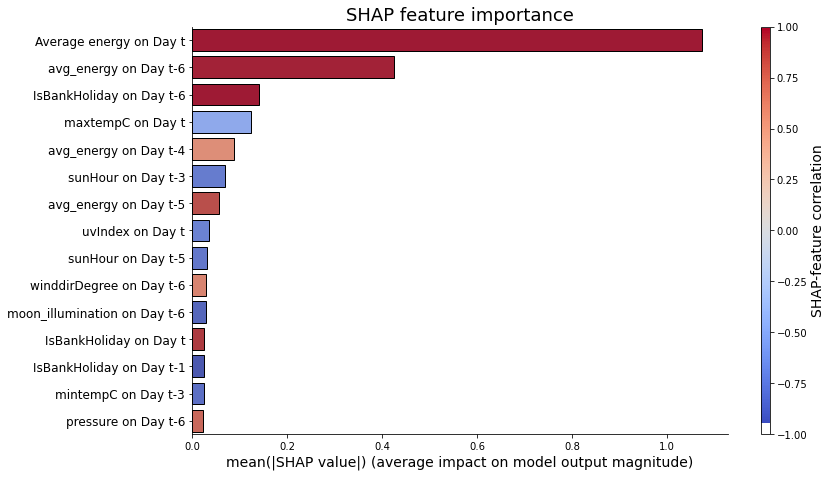

In [1168]:
import seaborn as sns
plot_abs_SHAP_summary(X_test, df_shap_oos, max_display=15, 
                      shap_name = 'all',clean_name_dict=clean_names,save=False)

In [1169]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
df_shap_oos = pd.DataFrame(data=shap_values, columns=X_test.columns, 
                       index=X_test.index)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [1170]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_SHAP_corrs(df_x, df_shap, format_dict=None, max_display=None):
    
    # Get correlations and importances
    corrs = df_x.corrwith(df_shap)
    shap_importances = df_shap.abs().mean()
    shap_importances.sort_values(ascending=False, inplace=True)
    corrs = corrs.loc[shap_importances.index]
    
    # Configure plot inputs
    if not max_display:
        max_display = 15
    corrs = corrs.iloc[:max_display]
    labels = corrs.index
    
    if format_dict:
        old_labels = labels
        labels = []
        for label in old_labels:
            labels.append(format_dict[label])
    
    # Plot
    plt.figure(figsize=(12,15*0.5))
    sns.barplot(x=corrs, y=np.arange(len(corrs)), orient='h', color='grey', edgecolor="black")
    sns.despine(top=True, right=True)
    plt.yticks(np.arange(len(corrs)), labels=labels, fontsize=12)
    plt.xlabel('Directional correlation', fontsize=14)
    plt.title('Feature correlations', fontsize=18)
    plt.savefig('Directional_correlation.jpg',dpi = 200, bbox_inches='tight')
    plt.show()

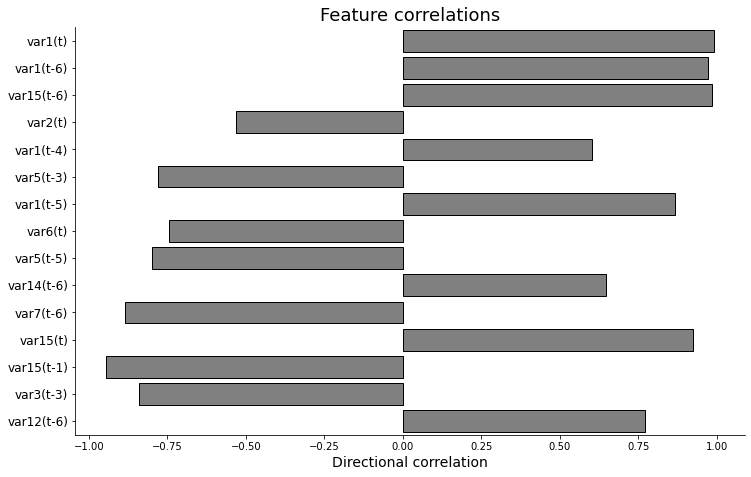

In [1171]:
plot_SHAP_corrs(X_test,df_shap_oos)

In [1172]:
#import the libraries for error calculation
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

#Calculate error of the model with RMSE, MSE, MAE, MAPE
print("RMSE: ",mean_squared_error(y_true, pred_list))
print("MSE: ",mean_squared_error(y_true, pred_list, squared=False))
print("MAE: ",mean_absolute_error(y_true, pred_list))
print("MAPE: ",mean_absolute_percentage_error(y_true, pred_list))

RMSE:  0.8671018003106722
MSE:  0.9311830111802256
MAE:  0.73213354387481
MAPE:  0.07305486657631162


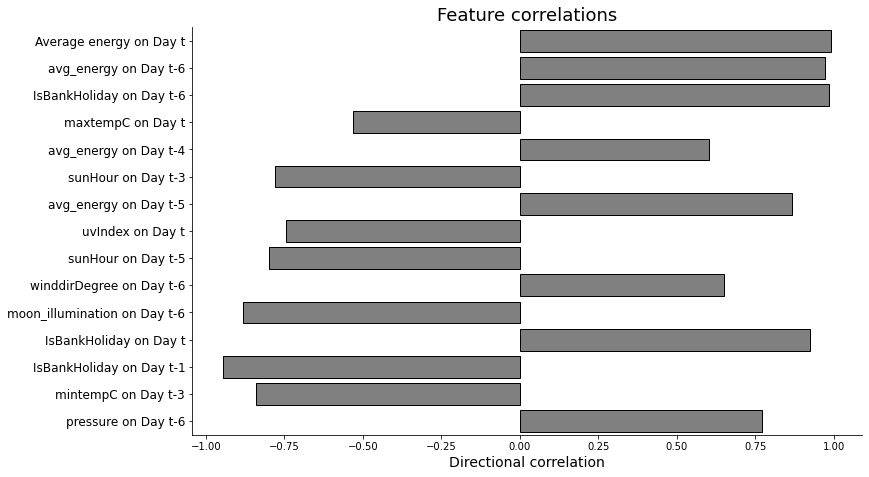

In [1174]:
plot_SHAP_corrs(X_test,df_shap_oos,format_dict=clean_names)